In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [10]:
train = pd.read_csv('data/no_normalize_data_train.csv')
test = pd.read_csv('data/no_normalize_data_test.csv')

In [11]:
X_train = train.drop(['label'], axis=1)
y_train = train['label']
X_test = test.drop(['label'], axis=1)
y_test = test['label']

In [19]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X_train)
print(d)
X_train = pd.DataFrame(d, columns=X_train.columns)
d = scaler.fit_transform(X_test)
print(d)
X_test = pd.DataFrame(d, columns=X_test.columns)

[[0.         0.01286912 0.09738294 ... 0.0644931  0.10122221 0.01281356]
 [0.         0.01286912 0.03952288 ... 0.0644931  0.10122221 0.01281356]
 [0.         0.01286912 0.09471248 ... 0.0644931  0.10122221 0.01281356]
 ...
 [1.         0.09024403 0.03329179 ... 0.01798474 0.19739731 0.58902962]
 [1.         0.09024403 0.02812889 ... 0.01798474 0.19739731 0.58902962]
 [1.         0.09024403 0.14456115 ... 0.01798474 0.19739731 0.58902962]]
[[0.         0.05477198 0.02030829 ... 0.02915311 0.02377856 0.02264808]
 [0.         0.05477198 0.02838268 ... 0.02915311 0.02377856 0.02264808]
 [0.         0.05477198 0.06092488 ... 0.02915311 0.02377856 0.02264808]
 ...
 [1.         0.38340386 0.02838268 ... 0.01411083 0.03108806 1.        ]
 [1.         0.38340386 0.03963788 ... 0.01411083 0.03108806 1.        ]
 [1.         0.38340386 0.08123318 ... 0.01411083 0.03108806 1.        ]]


In [20]:
X_train.head()

,transcript_id,transcript_position,-1_flank_length,-1_flank_std,-1_flank_mean,central_length,central_std,central_mean,+1_flank_length,+1_flank_std,...,-1_flank_length_std,-1_flank_std_std,-1_flank_mean_std,central_length_std,central_std_std,central_mean_std,+1_flank_length_std,+1_flank_std_std,+1_flank_mean_std,gene_id
0,0.0,0.012869,0.097383,0.017609,0.693095,0.025547,0.035586,0.673913,0.035452,0.014684,...,0.114449,0.019897,0.235959,0.255451,0.080439,0.207596,0.214301,0.064493,0.101222,0.012814
1,0.0,0.012869,0.039523,0.018678,0.603581,0.101026,0.041302,0.633152,0.007825,0.006867,...,0.114449,0.019897,0.235959,0.255451,0.080439,0.207596,0.214301,0.064493,0.101222,0.012814
2,0.0,0.012869,0.094712,0.023779,0.411765,0.115541,0.053133,0.687500,0.027626,0.019852,...,0.114449,0.019897,0.235959,0.255451,0.080439,0.207596,0.214301,0.064493,0.101222,0.012814
3,0.0,0.012869,0.022699,0.021010,0.641944,0.049158,0.028441,0.714674,0.065212,0.021920,...,0.114449,0.019897,0.235959,0.255451,0.080439,0.207596,0.214301,0.064493,0.101222,0.012814
4,0.0,0.012869,0.112516,0.018873,0.641944,0.116509,0.056048,0.673913,0.185440,0.051055,...,0.114449,0.019897,0.235959,0.255451,0.080439,0.207596,0.214301,0.064493,0.101222,0.012814


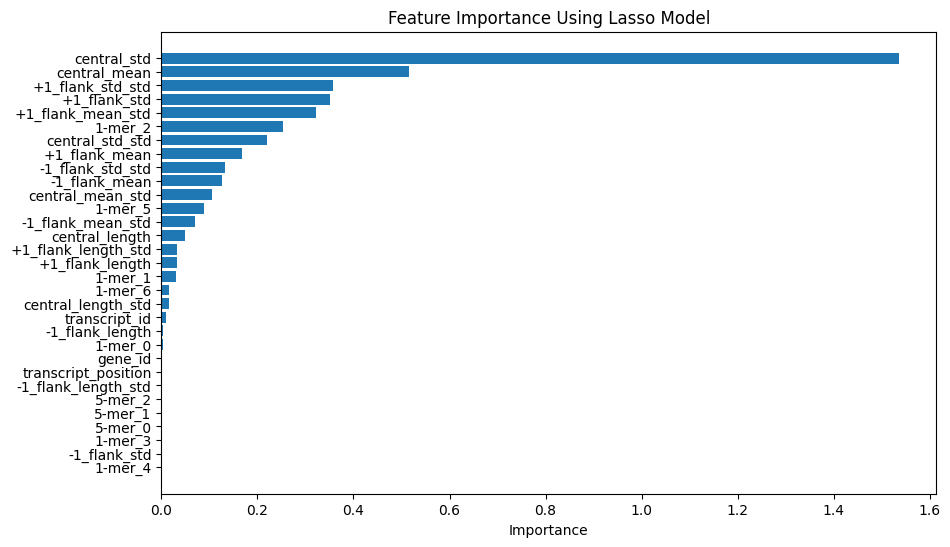

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(cv=5)  # 5-fold cross-validation
lasso_model.fit(X_train, y_train)
feature_importance = np.abs(lasso_model.coef_)

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Using Lasso Model')
plt.gca().invert_yaxis()  
plt.show()


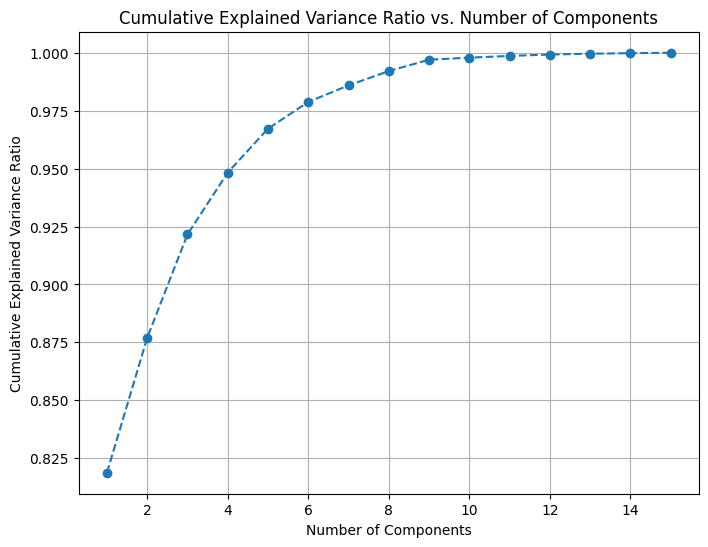

Number of components to retain 0.95 of variance: 5


In [47]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(X_train)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio vs. Number of Components")
plt.grid()
plt.show()

desired_variance_retained = 0.95
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio < desired_variance_retained]) + 1

print(f"Number of components to retain {desired_variance_retained} of variance: {n_components}")

In [71]:
import warnings
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

clf = XGBClassifier()
# clf = LogisticRegression()
rfe = RFE(estimator=clf, n_features_to_select=n_components)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") 
    rfe.fit(X_train, y_train)

In [72]:
selected_features = [f for f, s in zip(X_train.columns, rfe.support_) if s]
print(selected_features)

['central_std', '+1_flank_std', '-1_flank_std_std', '+1_flank_std_std', '+1_flank_mean_std']


In [73]:
X_train_drop = X_train[selected_features]
X_test_drop = X_test[selected_features]

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampledtrain, y_resampledtrain = smote.fit_resample(X_train_drop, y_train)
resampled_train = pd.DataFrame(data=X_resampledtrain, columns=X_train_drop.columns)
resampled_train['label'] = y_resampledtrain

In [75]:
resampled_train.head()

,central_std,+1_flank_std,-1_flank_std_std,+1_flank_std_std,+1_flank_mean_std,label
0,0.035586,0.014684,0.019897,0.064493,0.101222,0
1,0.041302,0.006867,0.019897,0.064493,0.101222,0
2,0.053133,0.019852,0.019897,0.064493,0.101222,0
3,0.028441,0.021920,0.019897,0.064493,0.101222,0
4,0.056048,0.051055,0.019897,0.064493,0.101222,0


In [76]:
y_train.value_counts()

label
0    1874300
1    1874300
Name: count, dtype: int64

In [77]:
X_train = resampled_train.drop(['label'], axis=1)
y_train = resampled_train['label']

In [78]:
y_train.value_counts()

label
0    1874300
1    1874300
Name: count, dtype: int64

In [79]:
y_test.value_counts()

label
0    452960
1     23680
Name: count, dtype: int64

In [80]:
X_train.columns

Index(['central_std', '+1_flank_std', '-1_flank_std_std', '+1_flank_std_std',
       '+1_flank_mean_std'],
      dtype='object')

In [81]:
X_train.head()

,central_std,+1_flank_std,-1_flank_std_std,+1_flank_std_std,+1_flank_mean_std
0,0.035586,0.014684,0.019897,0.064493,0.101222
1,0.041302,0.006867,0.019897,0.064493,0.101222
2,0.053133,0.019852,0.019897,0.064493,0.101222
3,0.028441,0.021920,0.019897,0.064493,0.101222
4,0.056048,0.051055,0.019897,0.064493,0.101222


### Innovation: Bayesian Optimisation with Hyperopt
source: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [82]:
# !pip3 install hyperopt

In [83]:
classification_objective = "reg:logistic" #'binary:logistic'
# Set alpha and beta based on your preferences for the trade-off between ROC AUC and PR AUC.
alpha = 0.5
beta = 0.5

In [84]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'objective': classification_objective,  # Use binary classification objective
    'seed': 0
}

In [85]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
from hyperopt import STATUS_OK

def objective(space):
    clf = xgb.XGBClassifier(
        n_estimators=space['n_estimators'], 
        objective=space['objective'], 
        max_depth=int(space['max_depth']), 
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), (X_test_drop, y_test)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric=["auc", "logloss"],  # Evaluate on both ROC AUC and log loss (which corresponds to negative PR AUC)
        early_stopping_rounds=10, verbose=False)
    
    y_pred_proba = clf.predict_proba(X_test_drop)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    pr_auc = average_precision_score(y_test, y_pred_proba[:, 1])
    
    # You can customize the combination of these metrics based on your preferences.
    # For instance, you can assign weights to each metric.
    combined_metric = alpha * roc_auc + beta * pr_auc
    
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print("Combined Metric:", combined_metric)
    
    return {'loss': -combined_metric, 'status': STATUS_OK }

# Then, you can run your hyperparameter optimization using this objective function.


In [86]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore") 
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1,
                        trials = trials)

ROC AUC:                                             
0.5477670299011398                                   
PR AUC:                                              
0.05625457504282015                                  
Combined Metric:                                     
0.30201080247198                                     
100%|██████████| 1/1 [01:00<00:00, 60.97s/trial, best loss: -0.30201080247198]


In [87]:
# version 6: reg:logistic 
best_model = xgb.XGBClassifier(colsample_bytree = best_hyperparams['colsample_bytree'], 
                                gamma= best_hyperparams['gamma'], 
                                max_depth= int(best_hyperparams['max_depth']), 
                                min_child_weight = best_hyperparams['min_child_weight'], 
                                reg_alpha = best_hyperparams['reg_alpha'], 
                                reg_lambda = best_hyperparams['reg_lambda'],
                                n_estimators = 180, 
                                objective = classification_objective)
best_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8430130414367301, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=6.0857229209368855,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=7.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, objective='reg:logistic', ...)

In [88]:
y_pred = best_model.predict(X_test_drop)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92    452960
           1       0.05      0.10      0.06     23680

    accuracy                           0.85    476640
   macro avg       0.50      0.50      0.49    476640
weighted avg       0.91      0.85      0.88    476640



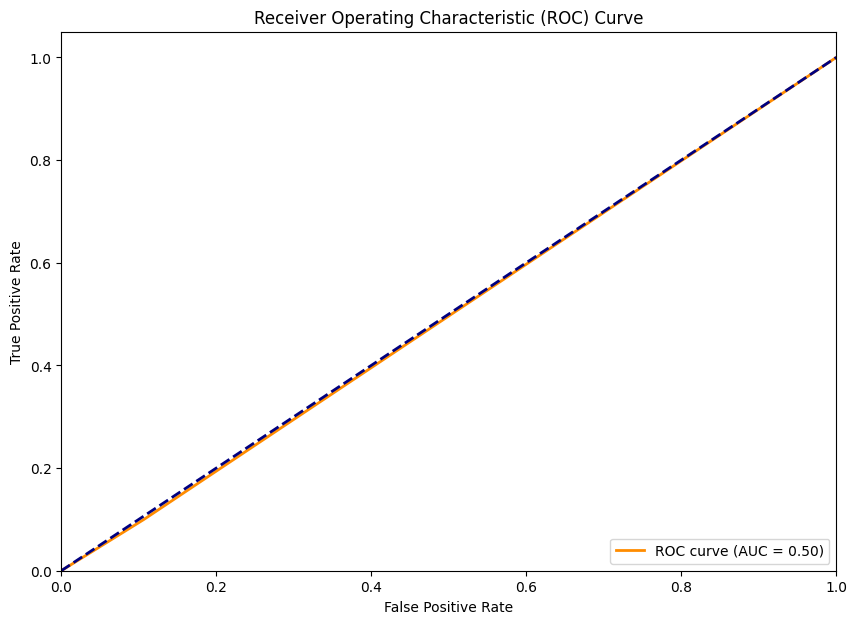

In [89]:
# ROC AUC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

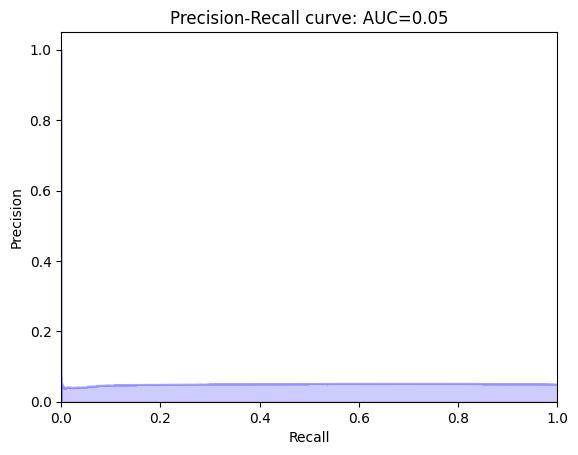

In [90]:
# Get predicted probabilities for the positive class (class 1)
from sklearn.metrics import average_precision_score, precision_recall_curve
y_pred_prob = best_model.predict_proba(X_test_drop)[:, 1]

# Calculate PR AUC
pr_auc = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve (optional)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(pr_auc))
plt.show()


In [91]:
# # output probabiliy 
# prob = best_model.predict_proba(X_test)[:,1]
# transcript_id = test['transcript_id']
# transcript_position = test['transcript_position']
# data = {
#     'transcript_id': transcript_id,
#     'transcript_position': transcript_position,
#     'probability': prob
# }

# # Create a DataFrame from the data dictionary
# output = pd.DataFrame(data)

# output.head()



In [92]:
test.head()

,transcript_id,transcript_position,-1_flank_length,-1_flank_std,-1_flank_mean,central_length,central_std,central_mean,+1_flank_length,+1_flank_std,...,-1_flank_std_std,-1_flank_mean_std,central_length_std,central_std_std,central_mean_std,+1_flank_length_std,+1_flank_std_std,+1_flank_mean_std,gene_id,label
0,5257,470,0.00332,2.82,112.0,0.01250,9.00,126.0,0.01100,2.63,...,3.356609,2.716422,0.005348,1.699429,3.391553,0.006624,0.909722,1.148867,6451,0
1,5257,470,0.00398,2.39,112.0,0.00631,7.82,121.0,0.01160,3.13,...,3.356609,2.716422,0.005348,1.699429,3.391553,0.006624,0.909722,1.148867,6451,0
2,5257,470,0.00664,7.71,111.0,0.02090,9.67,122.0,0.00992,2.11,...,3.356609,2.716422,0.005348,1.699429,3.391553,0.006624,0.909722,1.148867,6451,0
3,5257,470,0.00303,2.61,110.0,0.00827,5.24,121.0,0.02060,4.88,...,3.356609,2.716422,0.005348,1.699429,3.391553,0.006624,0.909722,1.148867,6451,0
4,5257,470,0.00611,2.57,114.0,0.01260,10.10,124.0,0.01030,3.62,...,3.356609,2.716422,0.005348,1.699429,3.391553,0.006624,0.909722,1.148867,6451,0


In [93]:
import joblib
joblib.dump(best_model, 'some_1_feature_selection_LR_0.95_model_with_std.pkl')

['some_1_feature_selection_LR_0.95_model_with_std.pkl']